In [2]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from category_encoders import LeaveOneOutEncoder

# Import supervised model types here:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# define where to find the data
path = "data/Video_Games_Sales_as_at_22_Dec_2016.csv"

<IPython.core.display.Javascript object>

## Data From: Kaggle:
## Video Game Sales and Ratings
### Video game sales data from VGChartz with corresponding ratings from Metacritic
### Kendall Gillies,  Rush Kirubi

This data set includes a 0-100 Critic Score, 0-10 User Score, and Critic and User counts on top of data describing the video games. Other descriptors include the Publisher, Developer, Name, Platform, and Year of Release, and Sales data for North America, Europe, Japan, 'Other', and total of these labeled Global Sales. In this project Global sales will be the target variable that will be predicted using the other columns of data. Without any further investigation, based on the description of the data, I'm going to guess that a boosted tree regression model is going to be the top performer. 

In [4]:
df = pd.read_csv(path)  # move data into a pandas dataframe
df.head()  # preview the top five rows

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

* Observe percentage of missing data per column.
* Drop rows with missing values.

In [7]:
df.isna().mean().sort_values(ascending=False)

User_Count         0.546025
User_Score         0.546025
Critic_Count       0.513308
Critic_Score       0.513308
Rating             0.404869
Developer          0.396136
Year_of_Release    0.016089
Publisher          0.003230
Genre              0.000120
Name               0.000120
Global_Sales       0.000000
Other_Sales        0.000000
JP_Sales           0.000000
EU_Sales           0.000000
NA_Sales           0.000000
Platform           0.000000
dtype: float64

<IPython.core.display.Javascript object>

Since only data entries with accompanying critic and user scores, will be used in the model the rest of data will be dropped

In [8]:
df = df.dropna(axis=0)

<IPython.core.display.Javascript object>

In [9]:
df = df.astype({"Year_of_Release": "int64"})

<IPython.core.display.Javascript object>

* Splitting the data to observe differences in predicting "Global_Sales" vs "NA_Sales". make smaller dataframe for pairplot.
* Models were tested on NA_sales and Global_Sales to see if there is a difference.
* Log plus 1 was used to improve the skewedness of target data. Manual cross-validation was done to proof-out better performance

In [10]:
df = df.assign(log_NA_Sales=np.log1p(df.NA_Sales))
df = df.assign(log_Global_Sales=np.log1p(df.Global_Sales))

<IPython.core.display.Javascript object>

* Feature engineering. 
    * Seeing how weighing the critic and user scores by their counts will act on the model 
    * Manual cross-validation was done to prove where these features are more useful

In [11]:
df["Critic_Combo"] = df["Critic_Count"] * df["Critic_Score"]
df["User_Combo"] = df["User_Count"] * df["User_Score"]

<IPython.core.display.Javascript object>

* Dropping obvious colinearity variables.

In [12]:
df_NA = df.drop(
    columns=["log_Global_Sales", "Global_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]
)
df_Global = df.drop(
    columns=["log_NA_Sales", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]
)

<IPython.core.display.Javascript object>

Seperating numerical and categorical data

In [13]:
df_NA_num = df_NA.select_dtypes(include=["float64", "int64"])
df_Global_num = df_Global.select_dtypes(include=["float64", "int64"])

<IPython.core.display.Javascript object>

In [12]:
# sns.pairplot(data=df_NA)
# plt.show()

<IPython.core.display.Javascript object>

In [13]:
# sns.pairplot(data=df_Global)
# plt.show()

<IPython.core.display.Javascript object>

Correlations on the log values are a little easier to visualize now.

In [14]:
df_NA_num.columns

Index(['Year_of_Release', 'NA_Sales', 'Critic_Score', 'Critic_Count',
       'User_Score', 'User_Count', 'log_NA_Sales', 'Critic_Combo',
       'User_Combo'],
      dtype='object')

<IPython.core.display.Javascript object>

In [17]:
df_NA_num_corr = df_NA_num.corr()["log_NA_Sales"][:]
golden_feature_list = df_NA_num_corr[abs(df_NA_num_corr) > 0.2].sort_values(
    ascending=False
)
print(
    "There is {} strongly correlated values with a column:\n{}".format(
        len(golden_feature_list), golden_feature_list
    )
)

There is 7 strongly correlated values with a column:
log_NA_Sales    1.000000
NA_Sales        0.832614
Critic_Combo    0.449285
Critic_Count    0.391210
Critic_Score    0.344018
User_Count      0.286709
User_Combo      0.284261
Name: log_NA_Sales, dtype: float64


<IPython.core.display.Javascript object>

Here, it looks like the User_Count is more important that the actual User_Score. 

In [18]:
df_Global_num_corr = df_Global_num.corr()["log_Global_Sales"][:]
golden_feature_list = df_Global_num_corr[abs(df_Global_num_corr) > 0.1].sort_values(
    ascending=False
)
print(
    "There is {} strongly correlated values with a column:\n{}".format(
        len(golden_feature_list), golden_feature_list
    )
)

There is 8 strongly correlated values with a column:
log_Global_Sales    1.000000
Global_Sales        0.783157
Critic_Combo        0.492343
Critic_Count        0.434604
Critic_Score        0.381688
User_Count          0.330166
User_Combo          0.325388
User_Score          0.152417
Name: log_Global_Sales, dtype: float64


<IPython.core.display.Javascript object>

Here, the effect of how outliers act on the model will be observed, and a closer look is taken of the impact of the new features.

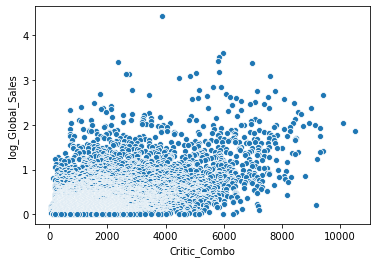

<IPython.core.display.Javascript object>

In [19]:
sns.scatterplot(x=df["Critic_Combo"], y=df["log_Global_Sales"])
plt.show()

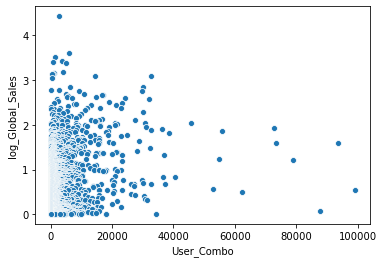

<IPython.core.display.Javascript object>

In [20]:
sns.scatterplot(x=df["User_Combo"], y=df["log_Global_Sales"])
plt.show()

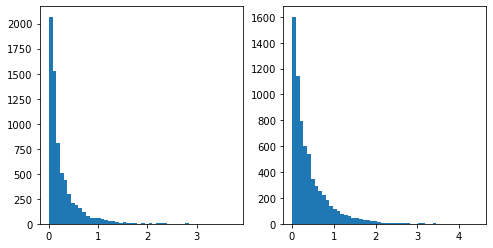

<IPython.core.display.Javascript object>

In [21]:
plt.figure(figsize = (8,4))
plt.subplot(121)
plt.hist(x=df["log_NA_Sales"], bins=50)
plt.subplot(122)
plt.hist(x=df["log_Global_Sales"], bins=50)
plt.show()


The box plots below show that outliers are primarily on the upper-end.
* removing outliers was not benificial to the model
* cross-validation of the 90th, 95th, 97th, adn 99th percetile was used resulting in decaying performance the lower the percentile used.

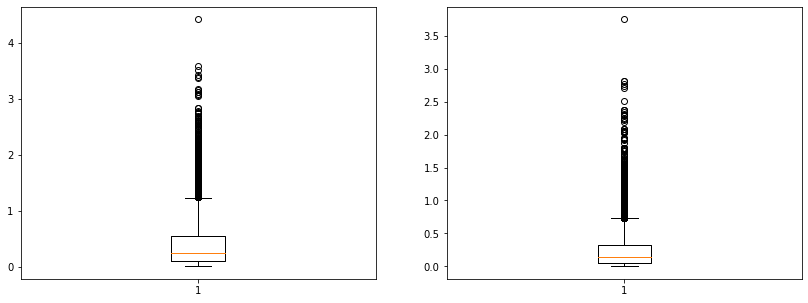

<IPython.core.display.Javascript object>

In [20]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.boxplot(np.log1p(df["Global_Sales"]))
plt.subplot(122)
plt.boxplot(np.log1p(df["NA_Sales"]))

plt.show()

Some of the 'Rating' catagory have too few entries. They will be dropped.

In [22]:
wantedRatings = (
    (df.Rating == "E") | (df.Rating == "M") | (df.Rating == "T") | (df.Rating == "E10+")
)
df = df.iloc[wantedRatings.values]

<IPython.core.display.Javascript object>

Next, outliers will be dropped in an attempt to improve the model's performance.

The data will be cut of the rows where the 'Global_Sales' is outside of the 90th, 95th, 97th, 99th, and 99.9th percentiles.

As seen below, the mean, and even the 75th percentile, is less than 1.

In [23]:
df["Global_Sales"].describe()

count    6822.000000
mean        0.777360
std         1.963754
min         0.010000
25%         0.110000
50%         0.290000
75%         0.750000
max        82.530000
Name: Global_Sales, dtype: float64

<IPython.core.display.Javascript object>

In [47]:
perc_90, perc_95, perc_97, perc_99, perc_999 = np.percentile(
    df["Global_Sales"], [90, 95, 97, 99, 99.9]
)
print(perc_90, perc_95, perc_97, perc_99, perc_999)

1.7 2.899499999999998 3.9958999999999927 7.1678999999999995 22.791290000000508


<IPython.core.display.Javascript object>

In [48]:
in_perc_90 = df.Global_Sales <= perc_90
in_perc_95 = df.Global_Sales <= perc_95
in_perc_97 = df.Global_Sales <= perc_97
in_perc_99 = df.Global_Sales <= perc_99
in_perc_999 = df.Global_Sales <= perc_999

df_90_G = df.iloc[in_perc_90.values]
df_95_G = df.iloc[in_perc_95.values]
df_97_G = df.iloc[in_perc_97.values]
df_99_G = df.iloc[in_perc_99.values]
df_999_G = df.iloc[in_perc_999.values]


<IPython.core.display.Javascript object>

In [25]:
perc_90, perc_95, perc_97, perc_99, perc_999 = np.percentile(df["NA_Sales"], [90, 95, 97, 99, 99.9])

in_perc_90 = df.NA_Sales <= perc_90
in_perc_95 = df.NA_Sales <= perc_95
in_perc_97 = df.NA_Sales <= perc_97
in_perc_99 = df.NA_Sales <= perc_99

df_90 = df.iloc[in_perc_90.values]
df_95 = df.iloc[in_perc_95.values]
df_97 = df.iloc[in_perc_97.values]
df_99 = df.iloc[in_perc_99.values]


<IPython.core.display.Javascript object>

* observe the distribution of 99th percentile of the target. 

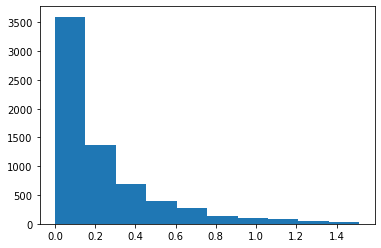

<IPython.core.display.Javascript object>

In [26]:
plt.hist(x=df_99["log_NA_Sales"])
plt.show()

Here it is decided to drop out some columns that are going to cause problems or be multilcolinear. 
It is safe to say that sales in other places will definitely be removed. Keeping them in would be cheating, and log_Global_Sales will be the target variable. 

In [24]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor


def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif

<IPython.core.display.Javascript object>

In [25]:
df_Global_num = df_Global.select_dtypes(include=["float64", "int64"])
df_Global_num = df_Global_num.drop(
    columns=[
        "Global_Sales",
        "log_Global_Sales",
        "User_Score",
        "User_Combo",
        "Critic_Count",
        "Critic_Score",
    ]
)

<IPython.core.display.Javascript object>

In [26]:
calc_vif(df_Global_num)

,variables,VIF
0,Year_of_Release,2.775790
1,User_Count,1.316186
2,Critic_Combo,3.268180


<IPython.core.display.Javascript object>

Some of the numeric columns where dropped due to multicolinearity

In [27]:
df_cats = df.select_dtypes(include=["object"])

<IPython.core.display.Javascript object>

In [28]:
df_cats.columns

Index(['Name', 'Platform', 'Genre', 'Publisher', 'Developer', 'Rating'], dtype='object')

<IPython.core.display.Javascript object>

* Now, to move on to the catagorical data.
    * Columns with too many unique elements were observed to see if they could be compressed. 
    * elements with less than a given threshold of hits are bagged together into a new element, "other". 

In [29]:
df_cats.Publisher.unique()

array(['Nintendo', 'Microsoft Game Studios', 'Take-Two Interactive',
       'Sony Computer Entertainment', 'Activision', 'Ubisoft',
       'Bethesda Softworks', 'Electronic Arts', 'SquareSoft',
       'GT Interactive', 'Konami Digital Entertainment', 'Square Enix',
       'Sony Computer Entertainment Europe', 'Virgin Interactive',
       'LucasArts', '505 Games', 'Capcom',
       'Warner Bros. Interactive Entertainment', 'Universal Interactive',
       'RedOctane', 'Atari', 'Eidos Interactive', 'Namco Bandai Games',
       'Vivendi Games', 'MTV Games', 'Sega', 'THQ',
       'Disney Interactive Studios', 'Acclaim Entertainment',
       'Midway Games', 'Deep Silver', 'NCSoft', 'Tecmo Koei',
       'Valve Software', 'Infogrames', 'Mindscape', 'Valve',
       'Hello Games', 'Global Star', 'Gotham Games',
       'Crave Entertainment', 'Hasbro Interactive', 'Codemasters',
       'TDK Mediactive', 'Zoo Games', 'Sony Oznline Entertainment', 'RTL',
       'D3Publisher', 'Black Label Games', 'So

<IPython.core.display.Javascript object>

In [30]:
df_cats.Platform.value_counts()

PS2     1140
X360     858
PS3      769
PC       650
XB       564
Wii      479
DS       464
PSP      390
GC       348
PS4      239
GBA      237
XOne     159
3DS      155
PS       149
PSV      118
WiiU      89
DC        14
Name: Platform, dtype: int64

<IPython.core.display.Javascript object>

In [31]:
df_cats.Genre.value_counts()

Action          1629
Sports           943
Shooter          864
Role-Playing     712
Racing           581
Platform         403
Misc             383
Fighting         378
Simulation       297
Strategy         266
Adventure        248
Puzzle           118
Name: Genre, dtype: int64

<IPython.core.display.Javascript object>

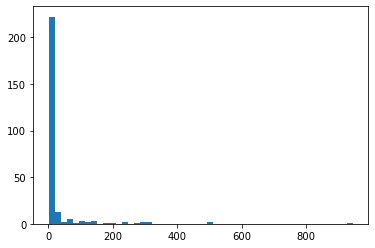

<IPython.core.display.Javascript object>

In [32]:
plt.hist(df_cats.Publisher.value_counts(), bins=50)
plt.show()

In [36]:
df.Publisher.value_counts().head(50)

Electronic Arts                           944
Ubisoft                                   496
Activision                                492
Sony Computer Entertainment               315
THQ                                       307
Nintendo                                  291
Sega                                      284
Take-Two Interactive                      272
Konami Digital Entertainment              244
Namco Bandai Games                        239
Capcom                                    197
Atari                                     176
Microsoft Game Studios                    141
Tecmo Koei                                137
Square Enix                               134
Warner Bros. Interactive Entertainment    130
Eidos Interactive                         123
Vivendi Games                             113
Codemasters                               111
Midway Games                              103
505 Games                                  80
Deep Silver                       

<IPython.core.display.Javascript object>

In [37]:
other_list = []
for i in range(df_cats.Publisher.nunique()):
    if df_cats['Publisher'].value_counts()[i] <=11:
        other_list.append(df_cats.Publisher.value_counts().index[i])


<IPython.core.display.Javascript object>

In [38]:
df.loc[df["Publisher"].isin(other_list), "Publisher"] = "Other"

<IPython.core.display.Javascript object>

In [39]:
df["Publisher"].nunique()

50

<IPython.core.display.Javascript object>

In [40]:
df.Publisher.value_counts()

Electronic Arts                           944
Other                                     606
Ubisoft                                   496
Activision                                492
Sony Computer Entertainment               315
THQ                                       307
Nintendo                                  291
Sega                                      284
Take-Two Interactive                      272
Konami Digital Entertainment              244
Namco Bandai Games                        239
Capcom                                    197
Atari                                     176
Microsoft Game Studios                    141
Tecmo Koei                                137
Square Enix                               134
Warner Bros. Interactive Entertainment    130
Eidos Interactive                         123
Vivendi Games                             113
Codemasters                               111
Midway Games                              103
505 Games                         

<IPython.core.display.Javascript object>

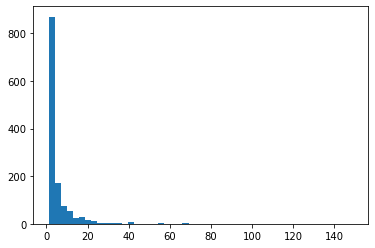

<IPython.core.display.Javascript object>

In [41]:
plt.hist(df.Developer.value_counts(), bins=50)
plt.show()

In [42]:
other_list = []
for i in range(df_cats.Developer.nunique()):
    if df_cats["Developer"].value_counts()[i] <= 22:
        other_list.append(df_cats.Developer.value_counts().index[i])

<IPython.core.display.Javascript object>

In [43]:
df.loc[df["Developer"].isin(other_list), "Developer"] = "Other"

<IPython.core.display.Javascript object>

In [44]:
df.Developer.value_counts().head(50)

Other                             4559
EA Canada                          149
EA Sports                          142
Capcom                             126
Ubisoft                            103
Konami                              95
Ubisoft Montreal                    87
EA Tiburon                          82
Omega Force                         69
Nintendo                            68
Visual Concepts                     68
Electronic Arts                     67
Traveller's Tales                   59
Codemasters                         57
Vicarious Visions                   57
Namco                               55
Yuke's                              48
TT Games                            43
Midway                              42
Maxis                               42
Neversoft Entertainment             42
Treyarch                            41
From Software                       41
Eurocom Entertainment Software      40
Square Enix                         39
Sonic Team               

<IPython.core.display.Javascript object>

Prepare to split data and start prepocessing

In [49]:
df_999_G = df.iloc[in_perc_999.values]

<IPython.core.display.Javascript object>

* another Check to see if removing outliers will help performance
    * the model performed worse again

In [50]:
drop_cols = [
    "Name",
    "NA_Sales",
    "Global_Sales",
    "EU_Sales",
    "JP_Sales",
    "Other_Sales",
    "Global_Sales",
    #    "Publisher",
    #     "Developer",
    "log_Global_Sales",
    "log_NA_Sales",
    "User_Score",
    #     "User_Count",
    "User_Combo",
    "Critic_Count",
    "Critic_Score",
    #     "Critic_Combo",
]

# X = df_999_G.drop(columns=drop_cols)
# y = df_999_G["log_Global_Sales"]
# y = df["Global_Sales"]

X = df.drop(columns=drop_cols)
y = df["log_Global_Sales"]



<IPython.core.display.Javascript object>

Train/Test split the data by 20% in the test group

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X.Rating
)

<IPython.core.display.Javascript object>

Define the specific columns and cats for easy entry in the preprocessing and pipeline. 

In [52]:
num_cols = [
    "Year_of_Release",
    "User_Count",
    #     "User_Score",
    #     "User_Combo",
    #     "Critic_Count",
    #     "Critic_Score",
    "Critic_Combo",
]
bin_cols = []
cat_cols = ["Platform", "Genre", "Rating", "Publisher", "Developer"]
drop_cats = ["PS4", "Sports", "E", "Other", "Other"]

<IPython.core.display.Javascript object>

## XGBoost Regression Model

In this model the parameters are fine tuned in iterations. Each run works with parameter values surrounding the best parameters found via grid search in the previous iteration, when applicable, until the returned best parameter values stop changing.

In [53]:
# fmt: off
preprocessing = ColumnTransformer([
    ("scale", StandardScaler(), num_cols), # scaling
    ("encode_cats", OneHotEncoder(drop=drop_cats), cat_cols), # dummy encoding
], remainder="passthrough")

<IPython.core.display.Javascript object>

In [54]:
# fmt: off
params = {
#     "model__subsample": [ 0.65, 0.75, .8, 1],
    "model__subsample": [0.4, 0.5, 0.65, 1.0],
#     "model__colsample_bytree": [ 0.75, 0.85, .90, 1],
    "model__colsample_bytree": [ 0.5, 0.75,  1.0],
    "model__max_depth": [7, 8, 9, 10],
#     "model__max_depth": [ 14, 18, 20],
}
n_trees = 100
learning_rate = 2 / n_trees

<IPython.core.display.Javascript object>

In [55]:
pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("model", XGBRegressor(n_estimators=n_trees, learning_rate=learning_rate)),
    ]
)

<IPython.core.display.Javascript object>

In [56]:
pipeline_cv = GridSearchCV(pipeline, params, verbose=1, n_jobs=-1, cv=2)

<IPython.core.display.Javascript object>

In [76]:
pipeline_cv.fit(X_train, y_train)

print(f"Train Score: {pipeline_cv.score(X_train, y_train)}")
print(f"Test Score: {pipeline_cv.score(X_test, y_test)}")

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:   53.5s finished


Train Score: 0.7773889100935761
Test Score: 0.5785640868000266


<IPython.core.display.Javascript object>

* There is no real difference in the predicting 'NA_Sales' vs 'Global_Sales'.
* Removing outliers in the Sales data only hurt the model.


99th percentile
* XGBOOST Regression: Params: {'model__colsample_bytree': 1,'model__max_depth': 10,'model__subsample': 0.75}
Train Score: 0.7091890031893382
Test Score: 0.5005489069929983

99th percentile
* XGBOOST Regression: Params: {'model__colsample_bytree': .85,'model__max_depth': 9,'model__subsample': 0.75}
Train Score: 0.6709216221163665
Test Score: 0.5014700261290725

99th percentile
* XGBOOST Regression: Params: {'model__colsample_bytree': .85,'model__max_depth': 8,'model__subsample': 0.75}
Train Score: 0.6343650050335347
Test Score: 0.5011677336836367

100 percentile
* XGBOOST Regression: Params: {'model__colsample_bytree': 1.0,'model__max_depth': 10,'model__subsample': 0.6}
Train Score: 0.7917334440524151
Test Score: 0.5429274948210776

100 percentile
* XGBOOST Regression: Params:{'model__colsample_bytree': 1.0, 'model__max_depth': 10, 'model__subsample': 0.5}
Train Score: 0.7773889100935761
Test Score: 0.5785640868000

The Grid Search has a tendency to allow overfitting by going for higher max_depth. The best "happy medium" I can get for this model is around a max_depth of 10.

In [82]:
pipeline_cv.best_params_

{'model__colsample_bytree': 1.0,
 'model__max_depth': 10,
 'model__subsample': 0.5}

<IPython.core.display.Javascript object>

In [96]:
y_pred = pipeline_cv.predict(X_test)
y_pred_exp = np.exp(y_pred)-1
y_test_exp = np.exp(y_test)-1
MAE = np.mean(abs(y_test_exp-y_pred_exp))
MAPE = np.mean(abs((y_test_exp-y_pred_exp)/y_test_exp))
print(MAE)
print(MAPE)


0.4419750520300961
2.004829049479101


<IPython.core.display.Javascript object>

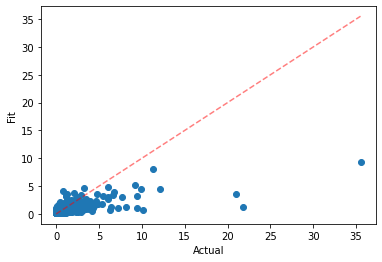

<IPython.core.display.Javascript object>

In [97]:
line_pts = [y_test_exp.min(), y_test_exp.max()]
plt.scatter(y_test_exp, y_pred_exp)
plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Fit")
plt.show()

## Lasso Model

This model uses L1 regularization.
* The parameter 'alpha' is used to determine how heavly the coefficients in the regression are penalized
* An iterative approach is used to help home in on the what order of "alpha" to use.
* Linear regression models are more transparent, and easier to interpret.

In [62]:
preprocessing.fit(X_train)

X_train_trans = preprocessing.transform(X_train)
X_test_trans = preprocessing.transform(X_test)

<IPython.core.display.Javascript object>

In [58]:
grid = {"alpha": [0.000001, 0.00001, 0.0001, 0.001]}

lasso_cv = GridSearchCV(Lasso(), grid, verbose=1, cv=5, n_jobs=-1)
lasso_cv.fit(X_train_trans, y_train)

# The best fit is in the best_estimator_ attribute
print(f"selected alpha: {lasso_cv.best_estimator_.alpha}")
lasso_cv.best_estimator_.coef_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   17.3s finished


selected alpha: 0.0001


array([-0.02686403,  0.10345174,  0.18133577, -0.03045825, -0.05105934,
        0.06554915, -0.0520268 , -0.13737539, -0.31028716,  0.33487096,
        0.12390163,  0.10204536,  0.00420106, -0.03114285,  0.14073579,
       -0.17857225, -0.00759396, -0.1516526 ,  0.04898697, -0.00103323,
       -0.09583839,  0.0432782 ,  0.07352229,  0.02190428, -0.10372673,
        0.03373428, -0.02062586,  0.00792548,  0.07714366, -0.0989931 ,
       -0.08920134, -0.05076615, -0.08544401, -0.10317242,  0.02113932,
       -0.        ,  0.16218228,  0.05426461, -0.03210719,  0.21610344,
       -0.07577328, -0.03505302, -0.03749071,  0.06907777,  0.        ,
        0.08947503, -0.01178773,  0.19590711,  0.        ,  0.        ,
        0.        , -0.20047898,  0.04760842,  0.14315417, -0.02393149,
        0.29147562,  0.        , -0.07132512,  0.1694375 , -0.03092075,
       -0.00373255,  0.2881544 , -0.0597159 , -0.        ,  0.        ,
       -0.07675882, -0.        ,  0.04696652, -0.08905985,  0.08

<IPython.core.display.Javascript object>

In [59]:
print(f"Train Score: {lasso_cv.score(X_train_trans, y_train)}")
print(f"Test Score: {lasso_cv.score(X_test_trans, y_test)}")

Train Score: 0.5004424762300013
Test Score: 0.4363681191247105


<IPython.core.display.Javascript object>

In [60]:
y_pred = lasso_cv.predict(X_test_trans)
y_pred_exp = np.exp(y_pred)
y_test_exp = np.exp(y_test)
MAE = np.mean(abs(y_test_exp - y_pred_exp))
MAPE = np.mean(abs((y_test_exp - y_pred_exp) / y_test_exp))
print(MAE)
print(MAPE)

0.49815808772055337
0.2307255301826962


<IPython.core.display.Javascript object>

This model is not overfitting as much as the XGBoost Reg model. 

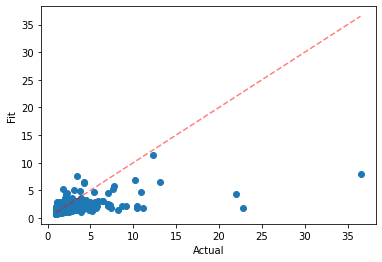

<IPython.core.display.Javascript object>

In [61]:
line_pts = [y_test_exp.min(), y_test_exp.max()]
plt.scatter(y_test_exp, y_pred_exp)
plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Fit")
plt.show()

## Elastic Net Model

This model uses Linear Regression with a combination of L1 and L2 regularization. 
* L1 regularization uses absolute value to minimize coefficients
* L2 regularization uses squaring to minimize coefficients. This make it more sensative to outliers.
* A grid search of the parameter shows that the model performs best with a 0.1 L1 ratio and an alpha value of 0.001

In [63]:
grid = {"alpha": [0.0001, 0.001, 0.01, 0.1], "l1_ratio": [0.1, 0.5, 0.75, 1]}
elasticnet_cv = GridSearchCV(ElasticNet(), grid, verbose=1)
elasticnet_cv.fit(X_train_trans, y_train)

print(f"selected alpha: {elasticnet_cv.best_estimator_.alpha}")
print(f"selected l1_ratio: {elasticnet_cv.best_estimator_.l1_ratio}")
elasticnet_cv.best_estimator_.coef_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   19.4s finished


selected alpha: 0.001
selected l1_ratio: 0.1


array([-2.96994921e-02,  1.03548078e-01,  1.83114169e-01, -2.87166416e-02,
       -3.23874638e-02,  5.93510486e-02, -5.10877976e-02, -1.34153575e-01,
       -3.06208801e-01,  3.16889253e-01,  1.19431671e-01,  1.01074259e-01,
        8.10476570e-04, -3.02081044e-02,  1.37361890e-01, -1.56760337e-01,
       -7.38942699e-03, -1.51759953e-01,  5.32418189e-02, -6.04453256e-04,
       -9.66378530e-02,  3.98367472e-02,  7.22398947e-02,  2.29054082e-02,
       -1.02098415e-01,  2.87512386e-02, -2.54741811e-02,  6.63728526e-03,
        7.36852760e-02, -1.02198308e-01, -8.71470701e-02, -5.47338726e-02,
       -8.66914994e-02, -8.20800280e-02,  1.01670077e-02, -7.36934598e-03,
        1.55263237e-01,  4.08699298e-02, -3.21610629e-02,  1.81585788e-01,
       -7.82103194e-02, -4.32587732e-02, -4.19887609e-02,  4.15593430e-02,
       -0.00000000e+00,  7.53737491e-02, -2.28366485e-02,  1.86497878e-01,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.74330165e-01,
        2.77055229e-02,  

<IPython.core.display.Javascript object>

In [64]:
print(f"Train Score: {elasticnet_cv.score(X_train_trans, y_train)}")
print(f"Test Score: {elasticnet_cv.score(X_test_trans, y_test)}")



Train Score: 0.4983736121658512
Test Score: 0.4387337501670767


<IPython.core.display.Javascript object>

In [65]:
y_pred = elasticnet_cv.predict(X_test_trans)
y_pred_exp = np.exp(y_pred)
y_test_exp = np.exp(y_test)
MAE = np.mean(abs(y_test_exp - y_pred_exp))
MAPE = np.mean(abs((y_test_exp - y_pred_exp) / y_test_exp))
print(MAE)
print(MAPE)

0.49783914648169936
0.2294457609658452


<IPython.core.display.Javascript object>

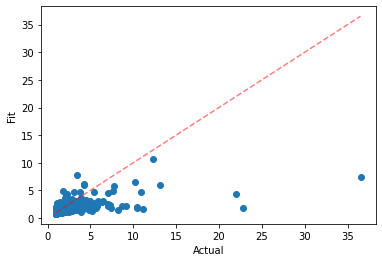

<IPython.core.display.Javascript object>

In [66]:
line_pts = [y_test_exp.min(), y_test_exp.max()]
plt.scatter(y_test_exp, y_pred_exp)
plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Fit")
plt.show()

## KNN model

K nearest neighbors regression can tackle a lot of same data as a linear regression model, but there need not be a linear relationship between the features and target.

In [67]:
pipeline = Pipeline([("preprocessing", preprocessing), ("knn", KNeighborsRegressor())])

<IPython.core.display.Javascript object>

In [68]:
ks = np.arange(1, 100, 2)
rmses = []

for k in ks:
    pipeline.named_steps["knn"].n_neighbors = k
    neg_rmses = cross_val_score(
        pipeline, X_train, y_train, scoring="neg_root_mean_squared_error"
    )
    avg_rmse = np.mean(-neg_rmses)
    rmses.append(avg_rmse)

<IPython.core.display.Javascript object>

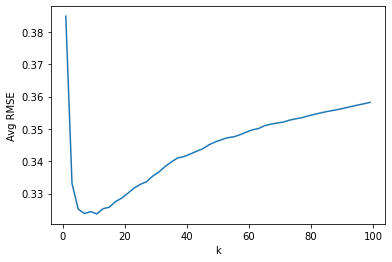

<IPython.core.display.Javascript object>

In [69]:
plt.plot(ks, rmses)
plt.xlabel("k")
plt.ylabel("Avg RMSE")
plt.show()

In [70]:
grid = {"knn__n_neighbors": np.arange(1, 100, 4)}
model = GridSearchCV(pipeline, grid)
model.fit(X_train, y_train)

model.best_params_

{'knn__n_neighbors': 9}

<IPython.core.display.Javascript object>

In [71]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))


0.6268449081496643
0.47299384988708193


<IPython.core.display.Javascript object>

In [72]:
y_pred = model.predict(X_test)
y_pred_exp = np.exp(y_pred)
y_test_exp = np.exp(y_test)
MAE = np.mean(abs(y_test_exp - y_pred_exp))
MAPE = np.mean(abs((y_test_exp - y_pred_exp) / y_test_exp))
print(MAE)
print(MAPE)

0.46583970748444586
0.20682120243831636


<IPython.core.display.Javascript object>

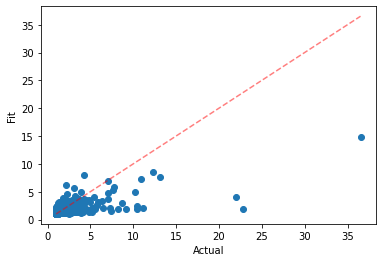

<IPython.core.display.Javascript object>

In [73]:
line_pts = [y_test_exp.min(), y_test_exp.max()]
plt.scatter(y_test_exp, y_pred_exp)
plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Fit")
plt.show()

#### Conclusion:

These models all seemed to have a limited amount of performance. The lack of performance in these models comes from the data. There is a lack of neccessary correlation for linear regression models, and the outliers that hurt the performance of the linear regression help add performance in the categorical components in the models. Selecting a best model for this situation depends on what trade-offs you are ok with. XGBOOST appears to perform well at first, but it is the least explainable, is prone to overfitting if you the max depth gets too high, and the mean absolute percentage error is the worst in this model. The KNN model in my opinion gave the best perfomance, but it isn't as transparent, nor is it as easy to explain as the linear regression models. 